In [ ]:
! pip install geopandas
! pip install pandana
! pip install mplleaflet

In [82]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point
import pylab as plt
%pylab inline
import mplleaflet as mpll
#import osmnx as ox
from IPython.display import Image
from pandana.loaders import osm

Populating the interactive namespace from numpy and matplotlib


/Users/nicholasjones/anaconda3/envs/geospatial_Pandana/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Session 2 - Further geospatial, APIs

### Part 1. Getting data from APIs

#### What are APIs, why use them?

Companies and organizations make certain data available through their Application Programming Interfaces (APIs). To use an API, you make a request to a remote web server via its HTTP address.

You can retrieve data from APIs instead of downloading a static file to your hard drive and reading it in. This is helpful where:
* you want the latest data in real time (eg. stock prices or weather)
* you want a small, selected piece of data (eg. hospital locations in a bounding box)
* the organization will run its own computations for you (eg. request satellite imagery with cloud cover removed, Planet API; analyze sentiment of a document, IBM Watson API).


|Example API|Functionality|
|---|---|
|Overpass API|Get OpenStreetMap data|
|Google Maps|Get point of interest locations, create distance features|
|Yahoo Stock|Get stock prices|
|Twitter, Youtube, Instagram|Get social media data|
|World Bank Indicators API|Get data from WDI, Doing Business etc|
|Socrata|City data portals|

#### Four steps to using APIs

1. Read the documentation

  APIs are rules specifying what query you should send, and what format of data the server will return back. You query APIs using an HTTP request (ie. a web address). Read the docs to check (i) what the API can do; (ii) what the HTTP request should look like. 
  

2. Find the API endpoint

  Examples: http://api.twitter.com, http://api.github.com


3. Try a sample query in your web brower or terminal: `curl https://api.github.com/users/nj935/repos`

  Queries start with the API endpoint, then add commands using the API's specific format. Send a sample query to see what the output looks like. Normally it will be Javascript Object Notation (JSON).


4. Extract the information you need from the JSON.

  Remember JSON is a widely used data interchange format. It comprises nested dictionaries and lists.


5. Write some code to send custom requests.

  The `requests` library is a painless way to make HTML requests. Using the API's rules and some lines of code, you can quickly request the precise data you want. There are also API wrappers (small Python libraries that manage API requests for you, providing an easier syntax).

### Worked example 1: How many humans in space?
    
A simple API, created by space travel enthusiasts, is [Open Notify](http://open-notify.org/). First find the endpoint.

In [83]:
endpoint_url = 'http://api.open-notify.org/astros.json'

In [84]:
response = requests.get(endpoint_url)

In [117]:
response.status_code

In [118]:
data = response.json()
data

In [87]:
people_in_space = data['number']

In [88]:
print("there are currently {} people in space".format(people_in_space))

there are currently 3 people in space


### Worked example 2: Mexico open data

**Objective:** Get data from a national Open Data Portal, convert lat / lon coordinates into a geometry object, plot maps.

* Look at the Government of Mexico open data portal: https://datos.gob.mx/.
* Inspect the Condiciones Atmosfericas link in your web browser or via `curl <url>`.

In [89]:
endpoint_url = 'https://api.datos.gob.mx/v1/condiciones-atmosfericas'

In [90]:
response = requests.get(endpoint_url)

In [91]:
data = response.json()

In [119]:
data['results'][0]['latitude']

In [93]:
df = pd.DataFrame(data['results'])

In [120]:
df.shape

In [121]:
df.dtypes

In [96]:
df.longitude = df.longitude.astype(float)
df.latitude = df.latitude.astype(float)
df.tempc = df.tempc.astype(float)

In [122]:
df.head(2)

In [123]:
df.tempc.describe()

In [99]:
gdf = gpd.GeoDataFrame(df)

In [124]:
gdf.head(2)

In [101]:
# Useful snippet to re-use:

gdf['geometry'] = list(zip(df.longitude, df.latitude))
gdf['geometry'] = [Point(geom) for geom in gdf.geometry]

In [125]:
df.tempc.value_counts().sort_index(ascending = True).plot(kind = 'barh')
plt.title('Latest temperatures in Mexico');

In [126]:
ax = gdf.plot(column = 'tempc', colormap = 'viridis')
mpll.display(fig = ax.figure)

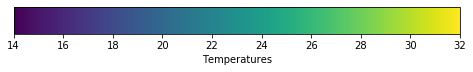

In [104]:
f, ax1 = plt.subplots(figsize = [8,0.5])
norm = mpl.colors.Normalize(df.tempc.min(), df.tempc.max())
cb1 = mpl.colorbar.ColorbarBase(ax1, norm = norm, orientation='horizontal')
cb1.set_label('Temperatures')

Documentation:
* the requests library ([click here](https://realpython.com/python-requests/))
* Pandas: [value_counts](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html), [df.plot()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)
* [customizing colorbars](https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html)
* [convert lat / lon columns to Geometry](https://medium.com/@shakasom/how-to-convert-latitude-longtitude-columns-in-csv-to-geometry-column-using-python-4219d2106dea)

## Worked example 3: OSM locations
**Objective:** Create an Area of Interest, download OpenStreetMap points of interest, intersect them with administrative boundaries

**Step 1: create an Area of Interest using www.geojson.io**

In [105]:
my_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -99.16671752929688,
              19.690435317911682
            ],
            [
              -99.43038940429686,
              19.508020154916768
            ],
            [
              -99.40155029296875,
              19.27744323287618
            ],
            [
              -99.25735473632812,
              19.182786626300352
            ],
            [
              -98.94012451171875,
              19.156843799897302
            ],
            [
              -98.81515502929688,
              19.540378338405763
            ],
            [
              -98.9208984375,
              19.730512997022263
            ],
            [
              -99.16671752929688,
              19.690435317911682
            ]
          ]
        ]
      }
    }
  ]
}

YOUR ACTION:

* Go to www.GeoJSON.io and draw a Polygon around an area that interests you. 
* Copy the text onto your clipboard. After the Mexico example, you can swap it into the cell above, and re-run.

In [108]:
gdf = gpd.GeoDataFrame.from_features(my_geojson)

In [127]:
ax = gdf.plot()
mpll.display(fig = ax.figure)

In [110]:
my_geom = gdf.geometry[0]

In [111]:
coords = my_geom.bounds

In [112]:
# Call the Overpass API using Pandana

amenities = ['hospital']  # others: school, clinic, restaurant, cafe, bank, pharmacy, park
osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))

In [113]:
pois = osm.node_query(coords[1],coords[0],coords[3],coords[2],tags=osm_tags)

In [114]:
#pois = ox.pois_from_polygon(my_geom, ['hospital'])
#pois = pois[['name','geometry']]

In [115]:
print("Found {} hospitals in AOI.".format(len(pois)))
pois.head()

Found 187 hospitals in AOI.


,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,addr:unit,alt_name,amenity,designation,email,...,note,old_name,opening_hours,operator,phone,toilets:wheelchair,website,wheelchair,wikidata,wikipedia:es
id,,,,,,,,,,,,,,,,,,,,,
319436637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hospital,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331600009,Cd de México,MX,26,11000,Acueducto Río Hondo,NaN,NaN,hospital,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364459687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hospital,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
471092318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hospital,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473053018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hospital,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Additional step - merge locations with admin districts
Geopandas lets you merge two sets of features based on their spatial relationship with each other (eg. Shape A contains Shape B, Shape A intersects Shape B).

In [ ]:
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/cdmx_shp/df_municipio.dbf
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/cdmx_shp/df_municipio.shp
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/cdmx_shp/df_municipio.shx
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/cdmx_shp/df_municipio.prj

In [34]:
CDMX_districts = gpd.read_file('df_municipio.shp')
CDMX_districts = CDMX_districts[['NOMGEO','geometry']]

In [ ]:
CDMX_districts.head()

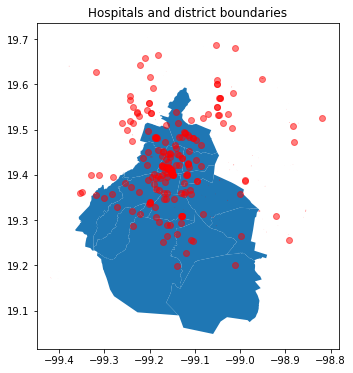

In [36]:
ax = CDMX_districts.plot(figsize = [6,6])
pois.plot(color = 'r', alpha = 0.5, ax = ax)
plt.title('Hospitals and district boundaries');

**--> we have some hospitals outside the boundaries.**
* Use a spatial join to merge the two dataframes by location.
* Append a new column to the POIs dataframe, with name of district that contains it.

In [128]:
pois = gpd.sjoin(pois, CDMX_districts)
print("After spatial join, we have {} hospitals.".format(len(pois)))
pois.head()

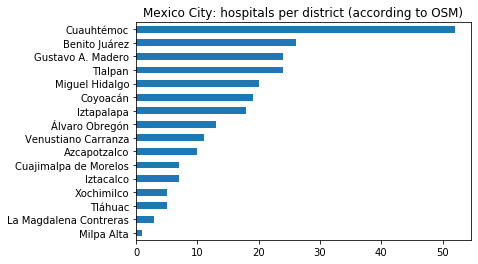

In [38]:
pois.NOMGEO.value_counts().sort_values(ascending = True).plot(kind = 'barh')
plt.title("Mexico City: hospitals per district (according to OSM)");

Documentation:
* [Spatial joins](http://wiki.gis.com/wiki/index.php/Spatial_Join) concept explained.
* Geopandas [sjoin](http://geopandas.org/mergingdata.html) function.

# Part 2: Nigeria consumption survey

The data below is from the Nigeria General Household Survey - Wave 3 (2015-2016). It's [available](http://microdata.worldbank.org/index.php/catalog/2936/datafile/F11) on the WB Microdata Library.

**Objective: Calculate and visualize average food consumption across Nigeria's regions**

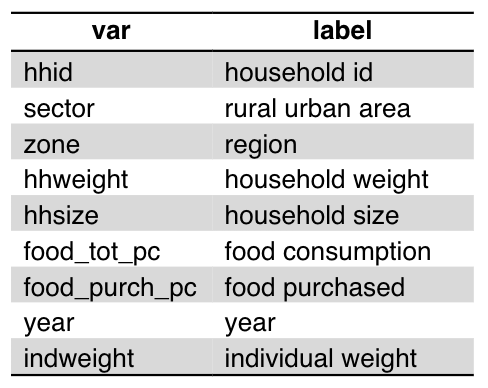

In [64]:
from IPython.display import Image
Image('https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/nigeria_table.png', width = 250)

In [65]:
df2 = pd.read_csv('https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/food2_pc.csv')

df2.rename(columns = {'hhweight':'household_weight','hhsize':'household_size','food_tot_pc':'food_consumption_pc',
           'food_purch_pc':'food_purchased_pc','indweight':'individual_weight'}, inplace=True)

df2.sector.replace({'1. URBAN': 'urban', '2. RURAL':'rural'}, inplace=True)
df2.zone.replace({'4. SOUTH EAST':'south_east', '2. NORTH EAST':'north_east', '5. SOUTH SOUTH':'south_south',
       '1. NORTH CENTRAL':'north_central', '6. SOUTH WEST':'south_west', '3. NORTH WEST':'north_west'}, inplace = True)

In [129]:
df2.head(2)

#### 1. Inspect data and remove outliers

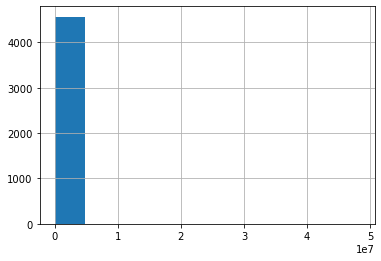

In [67]:
df2.food_consumption_pc.hist()

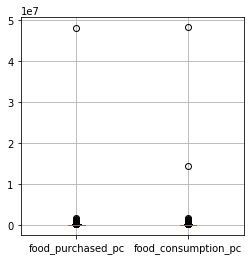

In [68]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

In [69]:
# Remove observations more than 3 standard deviations above the mean

df2['food_purchased_pc'][df2['food_purchased_pc'] > (df2.food_purchased_pc.mean()
                                                     + df2.food_purchased_pc.std() * 3)] = np.nan
df2['food_consumption_pc'][df2['food_consumption_pc'] > (df2.food_consumption_pc.mean() 
                                                         + df2.food_consumption_pc.std() * 3)] = np.nan
df2.dropna(inplace = True)

/Users/nicholasjones/anaconda3/envs/geospatial_Pandana/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nicholasjones/anaconda3/envs/geospatial_Pandana/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


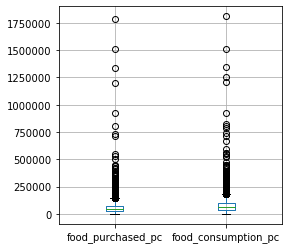

In [29]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

#### 2. Calculate mean food consumption by region, and by rural / urban.

The Pandas groupby function makes this easy. It does three things:
* Split the data into groups.
* Apply a function to each group independently (eg. sum, mean, counts).
* Combine the results into a data structure.

In [130]:
df2.groupby(['zone','sector'])['food_consumption_pc'].mean()

--> We plotted mean food consumption among 5000 surveyed households; doesn't represent population as a whole!

#### 3. Calculate mean food consumption for population

Weighted mean:

$$\overline x = \frac{\sum wx}{\sum w}$$

ie. sum of values times weights / sum of weights

In [31]:
sum(df2.food_purchased_pc * df2.individual_weight) / df2.household_weight.sum()

289663.4699519813

In [32]:
def weighted_mean(values, weights):
    return sum(values * weights) / weights.sum()

In [33]:
weighted_mean(values = df2.food_purchased_pc[df2.zone == 'south_east'],
             weights = df2.household_weight[df2.zone == 'south_east'])

73451.24198885933

In [34]:
weighted_means_table = pd.Series({zone: weighted_mean(df2.food_consumption_pc[df2.zone == zone],
                                  df2.household_weight[df2.zone == zone]) for zone in df2.zone.unique()},
                                name = 'mean_food_consumption_pc')

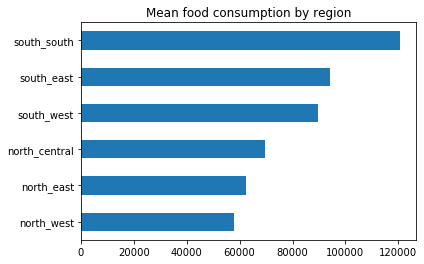

In [35]:
weighted_means_table.sort_values(ascending = True).plot(kind='barh')
plt.title('Mean food consumption by region');

#### 4. Visualize on a map of Nigeria
* A good data source is GADM, which has admin boundaries for all countries at levels 0 through 3 (national boundaries through to ward level). https://gadm.org/


* GADM1 gives us Nigeria's 36 states and capital territory. Our dataset uses the six [Geopolitical Zones](https://en.wikipedia.org/wiki/Geopolitical_zones_of_Nigeria) of Nigeria instead (these each comprise about 5-8 states). Create the required polygons by aggregating the state boundaries using Geopandas [dissolve](http://geopandas.org/aggregation_with_dissolve.html) function.

In [ ]:
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/nigeria/gadm36_NGA_1.shp?raw=true
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/nigeria/gadm36_NGA_1.shx?raw=true
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/nigeria/gadm36_NGA_1.cpg?raw=true
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/nigeria/gadm36_NGA_1.prj?raw=true
!wget https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%207/data/nigeria/gadm36_NGA_1.dbf?raw=true

In [ ]:
nigeria_GADM = gpd.read_file('gadm36_NGA_1.shp')

In [ ]:
nigeria_GADM.plot()

In [59]:
north_central = ['Benue','Kogi','Kwara', 'Nassarawa', 'Niger','Plateau', 'Federal Capital Territory']
north_east = ['Adamawa', 'Bauchi', 'Borno', 'Gombe', 'Taraba', 'Yobe']
north_west = ['Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Sokoto', 'Zamfara']
south_east = ['Abia', 'Anambra', 'Ebonyi', 'Enugu', 'Imo']
south_south = ['Akwa Ibom', 'Bayelsa', 'Cross River', 'Rivers', 'Delta', 'Edo']
south_west = ['Ekiti', 'Lagos', 'Ogun', 'Ondo', 'Osun', 'Oyo']

def remap_states(state):
    if state in north_east:
        return('north_east')
    elif state in north_central:
        return('north_central')
    elif state in north_west:
        return('north_west')
    elif state in south_east:
        return('south_east')
    elif state in south_south:
        return('south_south')
    elif state in south_west:
        return('south_west')
    else:
        return('error!')

A quick way to transform the rows or columns of a DataFrame is df.apply(). This runs a function of your choice across all the rows (axis = 0, the default) or all the columns (axis = 1).

In [ ]:
nigeria_GADM.head(2)

In [61]:
nigeria_GADM['region'] = nigeria_GADM.NAME_1.apply(remap_states)

In [62]:
# Create a new geodataframe comprising six merged polygons

regions = nigeria_GADM.dissolve(by = 'region')

In [ ]:
regions.head(2)

In [ ]:
regions.plot()

In [ ]:
# Check the two frames have the same length before merging

regions.shape

In [ ]:
weighted_means_table.shape

In [69]:
regions_merged = pd.merge(regions, weighted_means_table, left_index=True, right_index=True)

In [70]:
regions_merged = gpd.GeoDataFrame(regions_merged)

In [ ]:
regions_merged.plot(column = 'mean_food_consumption_pc', legend = True, figsize = [12,8])
plt.title('Mean food consumption per capita - regions of Nigeria');

Documentation:
* pandas [groupby](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) function
* pandas [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) function. 
* [choropleth](http://geopandas.org/mapping.html) maps in Geopandas
* [selecting and slicing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing) in Pandas